In [5]:
from datetime import datetime
import itertools
import json
import math

import geopandas
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import scipy
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils, database_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)
importlib.reload(database_utils)

RUN_FOLDER = "../results/3_mo_cross_val/"

conn = psycopg2.connect("dbname=" + "valle_db" + " user=" + "zack")

In [2]:
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])

In [6]:
database_utils.overwrite_shingles_table(conn, train_traces)

execute_mogrify() done


In [ ]:
# For all points; get adjacent points within x distance, y time that don't share a shingle
# For each shingle, average the speeds of all points that matched to each of its points
# Relate to observed mean speed of the shingle

In [22]:
adjacent_shingles = database_utils.get_adjacent_shingles(conn, .0001, 180, 5)
adjacent_shingles = pd.merge(adjacent_shingles, train_traces, left_on=['shingle','timeid_s'], right_on=['shingle_id', 'timeID_s'])
adjacent_shingles = adjacent_shingles.groupby('pred_shingle').mean(numeric_only=True)['speed_m_s'].reset_index()
adjacent_shingles.columns = ['pred_shingle','avg_adj_speed_m_s']

In [ ]:
# Could filter on bearing
# Could weight mean by distance and time
# Could use pace, percentiles, or schedule deviation

In [23]:
avg_shingle_speeds = train_traces.groupby('shingle_id').mean(numeric_only=True)['speed_m_s'].reset_index()
t = pd.merge(avg_shingle_speeds, adjacent_shingles, left_on="shingle_id", right_on="pred_shingle")
print(len(avg_shingle_speeds), len(adjacent_shingles))
t

47341 19263


,shingle_id,speed_m_s,pred_shingle,avg_adj_speed_m_s
0,6,12.067727,6,11.547752
1,9,8.576396,9,8.393097
2,10,3.338204,10,1.895371
3,16,8.313908,16,1.421909
4,17,7.835679,17,4.702001
...,...,...,...,...
19258,48048,9.322925,48048,7.482397
19259,48051,6.536661,48051,3.232611
19260,48052,9.934281,48052,18.952167
19261,48053,9.136000,48053,0.362377


0.06027244325387637


<AxesSubplot: xlabel='avg_adj_speed_m_s', ylabel='speed_m_s'>

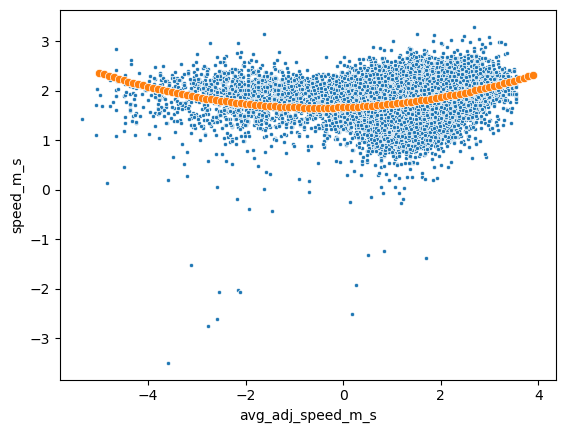

In [122]:
logx = np.log(t['avg_adj_speed_m_s'])
logy = np.log(t['speed_m_s'])

# Fit polynomial to the data
z = np.polyfit(logx, y=logy, deg=2)
x_val = np.arange(-5,4,.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((logy - p(logx))**2)
SST = np.sum((logy - np.mean(logy))**2)
print(1 - (SSR/SST))
sns.scatterplot(x=logx, y=logy, marker=".")
sns.scatterplot(x=x_val, y=y_val)

0.06582860138156288


<AxesSubplot: xlabel='avg_adj_speed_m_s', ylabel='speed_m_s'>

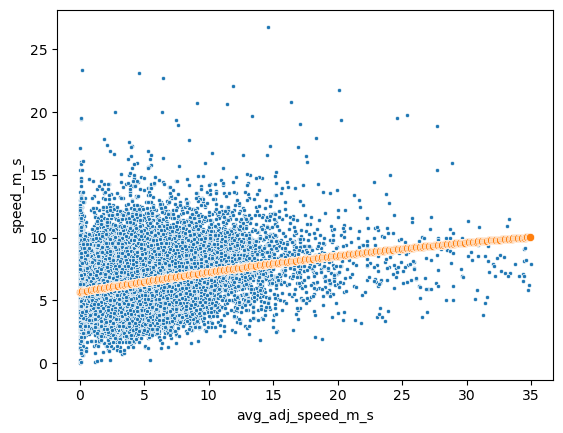

In [112]:
# Fit polynomial to the data
z = np.polyfit(x=t['avg_adj_speed_m_s'], y=t['speed_m_s'], deg=2)
x_val = np.arange(0,35,.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((t['speed_m_s'] - p(t['avg_adj_speed_m_s']))**2)
SST = np.sum((t['speed_m_s'] - np.mean(t['speed_m_s']))**2)
print(1 - (SSR/SST))
sns.scatterplot(x=t['avg_adj_speed_m_s'], y=t['speed_m_s'], marker=".")
sns.scatterplot(x=x_val, y=y_val)

In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt

points = np.random.uniform(-.5, .5, (100000,2))

# Compute the distance between each different pair of points in X with pdist.
# Then, just for ease of working, convert to a typical symmetric distance matrix
# with squareform.
dists = squareform(pdist(points))

poi = points[4] # point of interest
dist_min = .1
close_points = dists[4] < dist_min

print("There are {} other points within a distance of {} from the point "
    "({:.3f}, {:.3f})".format(close_points.sum() - 1, dist_min, *poi))

In [ ]:
f,ax = plt.subplots(subplot_kw=
    dict(aspect='equal', xlim=(-.5, .5), ylim=(-.5, .5)))
ax.plot(points[:,0], points[:,1], 'b+ ')
ax.plot(poi[0], poi[1], ms=15, marker='s', mfc='none', mec='g')
ax.plot(points[close_points,0], points[close_points,1],
    marker='o', mfc='none', mec='r', ls='')  # draw all points within distance

t = np.linspace(0, 2*np.pi, 512)
circle = dist_min*np.vstack([np.cos(t), np.sin(t)]).T
ax.plot((circle+poi)[:,0], (circle+poi)[:,1], 'k:') # Add a visual check for that distance
plt.show()